In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split

from pyarrow import csv
import json



In [49]:
data_path ='../data/'
# Json 파일 읽어오기
def read_json(jsonPath ,mod = 'r',encoding ='utf-8'):
    with open(jsonPath, mod, encoding = encoding) as common:
        config = json.load(common)
    return config
config = read_json(data_path + "json/config.json")

def transColName(cols):
    cols = cols.replace(' (%)', '')
    cols = cols.replace(' (명)', '')
    cols = cols.replace('[명]', '')
    cols = cols.replace('[백분율]', '')
    cols = cols.replace(')', '')
    cols = cols.replace('(', '_')
    cols = cols.replace(' ', '_')
    cols = cols.replace('1', '')
    return cols 


In [3]:

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/mean_predict.csv').to_pandas()
mean_predict =mean_predict[(mean_predict.년도 >= 2002)&(mean_predict.년도 <= 2019)&(mean_predict.시도 != '세종')]
df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
crime_val = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15]
crime_val['범죄소계'] = crime_val.iloc[:,2:].sum(axis = 1)
merged = pd.merge(crime_val, mean_predict, left_on=['시도','년도'], right_on=['시도','년도'], how='right')
merged.columns =  list(map(transColName,merged.columns))


# GridSearchCV를 이용하여 hyperParameter 튜닝 (최적값 구하기)

In [4]:
#GridSearchCV를 이용하여 hyperParameter 튜닝 함수
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01,0.1,0.2,0.3],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'gamma':[i/10.0 for i in range(0,5,2)],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }
    xgb_model = XGBRegressor()
    gsearch = GridSearchCV(
        estimator = xgb_model,
        param_grid = param_tuning,
        cv = 5,
        n_jobs = -1,
        verbose = 1
        )
    gsearch.fit(X_train,y_train)
    return gsearch.best_params_

In [208]:
# 모든 범죄에 대한 HyperParameter 구하기
x = merged.iloc[:,16:]
y = merged.iloc[:,2:16]

flag = True
for colName in y.columns:
    x_train, x_test ,y_train,y_test = train_test_split(x,y[colName],test_size=.2)
    hyper_tuned  = pd.DataFrame([hyperParameterTuning(x_train,y_train)])
    hyper_tuned['crime'] = colName
    if flag:
        result = hyper_tuned.copy()
        flag =False
    else :
        result = result.append(hyper_tuned)    


result.to_csv('xgboost_tuned.csv',encoding="utf-8-sig")

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


C:\Users\painc\Anaconda3\envs\iitp_keras\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


# 예측모델 생성

In [10]:

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/mean_predict.csv').to_pandas()
mean_predict =mean_predict[(mean_predict.시도 != '세종')]
df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
crime_val = df[(df.시도 != '세종')].iloc[:,:15]
crime_val['범죄소계'] = crime_val.iloc[:,2:].sum(axis = 1)
merged = pd.merge(crime_val, mean_predict, left_on=['시도','년도'], right_on=['시도','년도'], how='right')
xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]

In [11]:
crime_val = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by=['시도','년도'])
mean_predict =mean_predict[(mean_predict.년도 >= 2002)&(mean_predict.년도 <= 2019)&(mean_predict.시도 != '세종')].sort_values(by=['시도','년도'])


In [12]:
result=  pd.DataFrame()
predict= mean_predict[mean_predict.년도 >=2020]

# 예측 테스트

In [13]:
# 2018까지로 2019예측 
crime_val = df[(df.년도 >= 2002)&(df.년도 <= 2018)&(df.시도 != '세종')].iloc[:,:15].sort_values(by=['시도','년도'])
crime_val.columns =  list(map(transColName,crime_val.columns))
crime_val['범죄소계'] = crime_val.sum(axis = 1)

predict_2018 = mean_predict[(mean_predict.년도 >= 2002)&(mean_predict.년도 <= 2018)&(mean_predict.시도 != '세종')].sort_values(by=['시도','년도'])
predict_2018.columns =  list(map(transColName,predict_2018.columns))

predict_2019 = mean_predict[(mean_predict.년도 == 2019)&(mean_predict.시도 != '세종')].sort_values(by=['시도','년도'])
predict_2019.columns =  list(map(transColName,predict_2019.columns))

xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]

result = pd.DataFrame()

for tuned in xgboost_tuned.itertuples():    
    xgb_model = XGBRegressor(
        colsample_bytree = tuned[1],
        gamma = tuned[2],
        learning_rate = tuned[3],
        max_depth = tuned[4],
        min_child_weight = tuned[5],
        n_estimators = tuned[6],
        objective = tuned[7],
        subsample = tuned[8]
    )
    x_train, x_test ,y_train,y_test = train_test_split(predict_2018.iloc[:,2:],crime_val[tuned[9]],test_size=.2)
    xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False)
    result[tuned[9]] = xgb_model.predict(predict_2019.iloc[:,2:])
result


<ipython-input-13-8e8643ad2300>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  crime_val['범죄소계'] = crime_val.sum(axis = 1)


,절도,살인,강도,방화,성폭력,폭행및상해,공갈및협박,약취와_유인,체포와_감금,주거침입,유기,공무방해,도주와범인은닉,범죄소계
0,4739.433594,23.458647,60.208179,40.750961,850.260437,7326.270508,576.662415,3.301826,47.403797,507.365417,0.554386,381.594208,18.790010,15854.983398
1,40333.179688,195.935806,206.302002,323.714233,6914.791992,51570.468750,4826.927734,29.379364,336.956787,2860.900391,0.687500,2420.850830,73.266785,108834.937500
2,12635.257812,61.494232,85.628304,95.520370,1681.991455,13635.988281,1350.160034,6.175064,82.922989,764.632446,0.554386,1025.883423,35.256866,34070.632812
3,7836.069824,45.701004,75.148979,66.018059,1093.671265,9351.848633,994.504761,5.557578,59.548229,582.687500,0.554386,538.533936,20.372818,21161.810547
4,4766.830566,24.040554,46.656601,35.801628,1368.618896,7312.421875,565.966492,3.123507,54.129589,343.626953,0.554386,223.470337,17.328287,17475.027344
5,10841.560547,36.889999,80.274147,82.552711,1255.950562,11354.986328,923.879761,5.462773,59.559021,467.592957,0.554386,651.938110,24.674904,26600.607422
6,5130.471191,26.884966,72.666290,41.423180,969.202637,6876.984375,678.606995,3.889265,54.264305,372.652618,0.554386,335.645233,17.863773,17543.484375
7,13395.793945,55.109219,93.611504,94.750031,1849.035645,14920.039062,1269.008545,7.554425,85.285179,766.041260,0.554386,923.661621,36.314007,37891.105469
8,40217.148438,170.511169,544.767578,259.893188,9011.063477,45627.718750,3467.064209,28.979023,229.891479,2672.578613,1.680000,3006.759033,63.699368,105940.250000
9,3266.722656,18.190208,64.833694,27.956779,776.941467,4022.402832,272.605560,2.787176,21.646570,197.287582,0.500000,220.884979,12.815060,8996.967773


In [52]:
mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/mean_predict.csv').to_pandas()

y = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by=['시도','년도']).iloc[:,2:]
y['범죄소계'] = y.sum(axis =1)
x = mean_predict[(mean_predict.년도 >= 2002)&(mean_predict.년도 <= 2019)&(mean_predict.시도 != '세종')].iloc[:,2:]
predict_ = mean_predict[mean_predict.년도 >=2020]

y.columns =  list(map(transColName,y.columns))
x.columns =  list(map(transColName,x.columns))
predict_.columns =  list(map(transColName,predict_.columns))

result = pd.DataFrame()

for tuned in xgboost_tuned.itertuples():    
    xgb_model = XGBRegressor(
        colsample_bytree = tuned[1],
        gamma = tuned[2],
        learning_rate = tuned[3],
        max_depth = tuned[4],
        min_child_weight = tuned[5],
        n_estimators = tuned[6],
        objective = tuned[7],
        subsample = tuned[8]
    )
    x_train, x_test ,y_train,y_test = train_test_split(x,y[tuned[9]],test_size=.2)
    xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False)
    result[tuned[9]] = xgb_model.predict(predict_.iloc[:,2:])
pd.concat([predict_.iloc[:,:2].reset_index(drop = True),result],axis = 1)


,시도,년도,절도,살인,강도,방화,성폭력,폭행및상해,공갈및협박,약취와_유인,체포와_감금,주거침입,유기,공무방해,도주와범인은닉,범죄소계
0,강원,2020,7320.138184,31.612812,115.168365,66.609787,643.287354,7304.926270,418.570129,4.059346,26.311054,328.789154,0.575802,631.967224,22.493608,11050.761719
1,강원,2021,5371.651367,33.694775,9.638393,67.778061,944.488525,9418.492188,853.835815,4.461874,71.381973,597.662292,0.530208,459.345551,19.321964,18875.062500
2,강원,2022,5476.208984,34.420460,-6.949918,65.583961,956.484985,9674.686523,766.229187,4.460187,61.593052,616.228882,0.530208,485.208984,19.281031,18790.492188
3,강원,2023,5591.741211,35.016094,-6.949918,66.308258,995.303345,9830.767578,790.211731,4.516221,64.985252,628.357422,0.530208,492.546631,19.067516,19012.013672
4,강원,2024,5566.219727,35.248146,-6.949918,69.012115,993.816528,9804.864258,990.739502,4.870681,73.216873,650.345276,0.530208,497.831055,19.152491,12344.331055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,서울,2026,6623.315430,42.429413,94.262077,105.280228,1731.242188,9442.071289,1033.334106,4.712559,88.159973,801.127014,0.575802,764.232117,28.187733,12612.500000
172,서울,2027,6623.315430,52.401810,125.787193,106.306190,1731.242188,9854.244141,1234.931274,4.733406,88.159973,971.773376,0.575802,719.540588,28.155760,13125.786133
173,서울,2028,6678.869141,50.452698,125.787193,104.263130,1871.090088,9841.140625,1274.993286,4.954249,88.159973,973.583557,0.575802,719.540588,27.823183,17731.480469
174,서울,2029,6492.742188,49.771606,302.991913,101.739098,1871.090088,9841.140625,1335.884888,5.236125,86.616501,975.969666,0.575802,713.655945,27.944006,17731.480469


In [148]:
tmp = pd.DataFrame()
tmp['시도'] = predict_2019.시도.unique()
tmp[result.columns] = result
tmp = tmp.drop('범죄소계',axis =1)
df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()

df = df[(df.년도 == 2019)&(df.시도 != '세종')].iloc[:,:15].drop('년도',axis= 1)
df.columns = df.columns+'real'
df.rename(columns={'시도real':'시도'},inplace=True)
print(tmp.shape,df.shape)

(16, 14) (16, 14)


In [126]:
# MinMaxScale1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
predict_2018 = mean_predict[(mean_predict.년도 >= 2002)&(mean_predict.년도 <= 2018)&(mean_predict.시도 != '세종')].sort_values(by=['시도','년도'])
predict_2018.columns =  list(map(transColName,predict_2018.columns))
result_2018=pd.DataFrame(columns=predict_2018.columns)

scaler.fit(predict_2018[predict_2018.시도 == '강원'].iloc[:,2:])
# a = scaler.transform(predict_2018[predict_2018.시도 == '강원'].iloc[:,2:]) 

result_2018 = pd.concat([
    predict_2018[predict_2018.시도 == '강원'][['시도','년도']].reset_index(drop=True),
    pd.DataFrame(
        scaler.transform(predict_2018[predict_2018.시도 == '강원'].iloc[:,2:]) ,
        columns=predict_2018.columns[2:])
],axis = 1)
# a = a[a.columns[-2:].append(a.columns[:-2])]
# a


In [6]:
from matplotlib import font_manager,rc
from matplotlib import pyplot as plt
import math
def plot_(city = '강원'):
    plt.clf()
    plt.rcParams["figure.figsize"] = (30, 10)
    
    df= result.append(y)
    df.columns =  list(map(transColName,df.columns))
    
    font_path = "C:/Windows/Fonts/malgunbd.ttf" # 폰트 파일 위치
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
    cnt = 1
    plot_shape = math.ceil(math.sqrt(len(df.columns))) 

    for colName in df.columns[2:]:
        # plt.figure(figsize=(6,8))
        
        plt.rcParams["figure.figsize"] = (30, 10)
        plt.subplot(plot_shape,plot_shape,cnt)
        plt.bar(df[df.시도 == city]['년도'],df[df.시도 == city][colName],color = 'blue',alpha=0.5)
        plt.title(colName)
        plt.tight_layout()
        cnt+=1
    # plt.savefig('../img/'+fileName)
    plt.show()


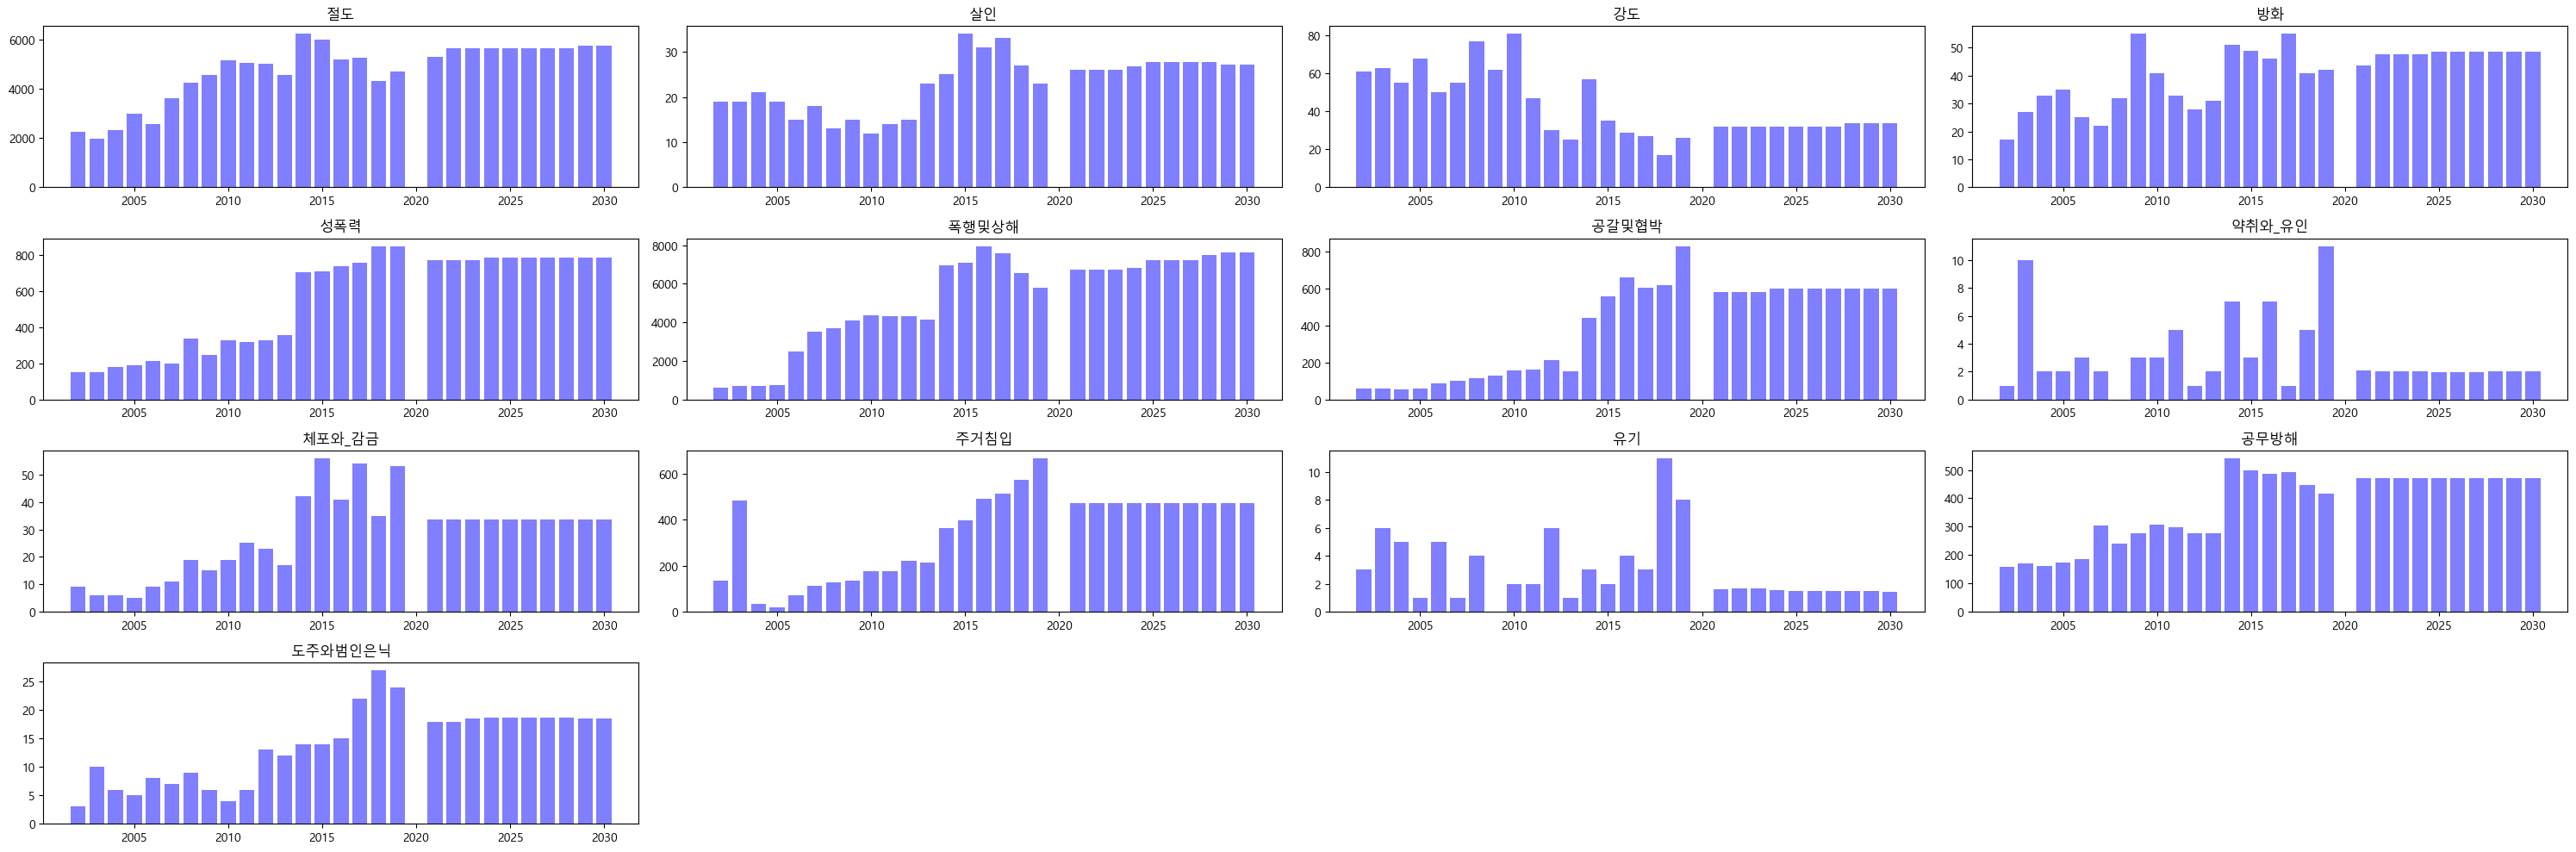

In [315]:
# MinMaxScale1 시도별 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/regression_predict.csv').to_pandas()
mean_predict = mean_predict[mean_predict.시도 != '세종']
tmp_ = mean_predict[mean_predict.시도 == '강원']
tmp_.columns =  list(map(transColName,tmp_.columns))

indi =pd.DataFrame(columns=mean_predict.columns)
# 각 시도별 minmaxScaling
for city in mean_predict.시도.unique():
    scaler.fit(mean_predict[mean_predict.시도 == city].iloc[:,2:])
    indi =indi.append(pd.concat([
        mean_predict[mean_predict.시도 == city][['시도','년도']].reset_index(drop=True),
        pd.DataFrame(
            scaler.transform(mean_predict[mean_predict.시도 ==city].iloc[:,2:]) ,
            columns=mean_predict.columns[2:])
    ],axis = 1))
# indi[indi.시도 == '강원'].head()
# mean_predict[mean_predict.시도 == '강원']['경찰청 인원 1명당 담당 인구'].max()

indi.columns =  list(map(transColName,indi.columns))
x = indi[(indi.년도 >= 2002)&(indi.년도 <= 2019)].sort_values(by = ['시도','년도']).reset_index(drop=True)
predict=  indi[indi.년도 > 2019].sort_values(by = ['시도','년도']).reset_index(drop=True)

df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
df.columns =  list(map(transColName,df.columns))
y = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by = ['시도','년도']).reset_index(drop=True)

xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]
xgboost_tuned = xgboost_tuned[xgboost_tuned['crime'] != '범죄소계']

result = pd.DataFrame()

flag = True
for city in x.시도.unique():
    tmp_pre = pd.DataFrame()
    # 범죄별예측
    for tuned in xgboost_tuned.itertuples():    
        xgb_model = XGBRegressor(
            colsample_bytree = tuned[1],
            gamma = tuned[2],
            learning_rate = tuned[3],
            max_depth = tuned[4],
            min_child_weight = tuned[5],
            n_estimators = tuned[6],
            objective = tuned[7],
            subsample = tuned[8]
        )

        x_train, x_test ,y_train,y_test = train_test_split(x[x.시도 == city].iloc[:,2:],y[y.시도 == city][tuned[9]],test_size=.2)
        xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False) 
        tmp_pre[tuned[9]] = xgb_model.predict(predict.iloc[:,2:]) 
    
    tmp_pre['시도'] = predict[predict.시도 == city].시도
    tmp_pre['년도'] = predict[predict.시도 == city].년도
    tmp_pre = tmp_pre[tmp_pre.columns[-2:].append(tmp_pre.columns[:-2])]
    
    if flag:
        result = tmp_pre
        flag = False
    else:
        result = pd.concat([result,tmp_pre])
        result.reset_index(drop = True)
plot_()


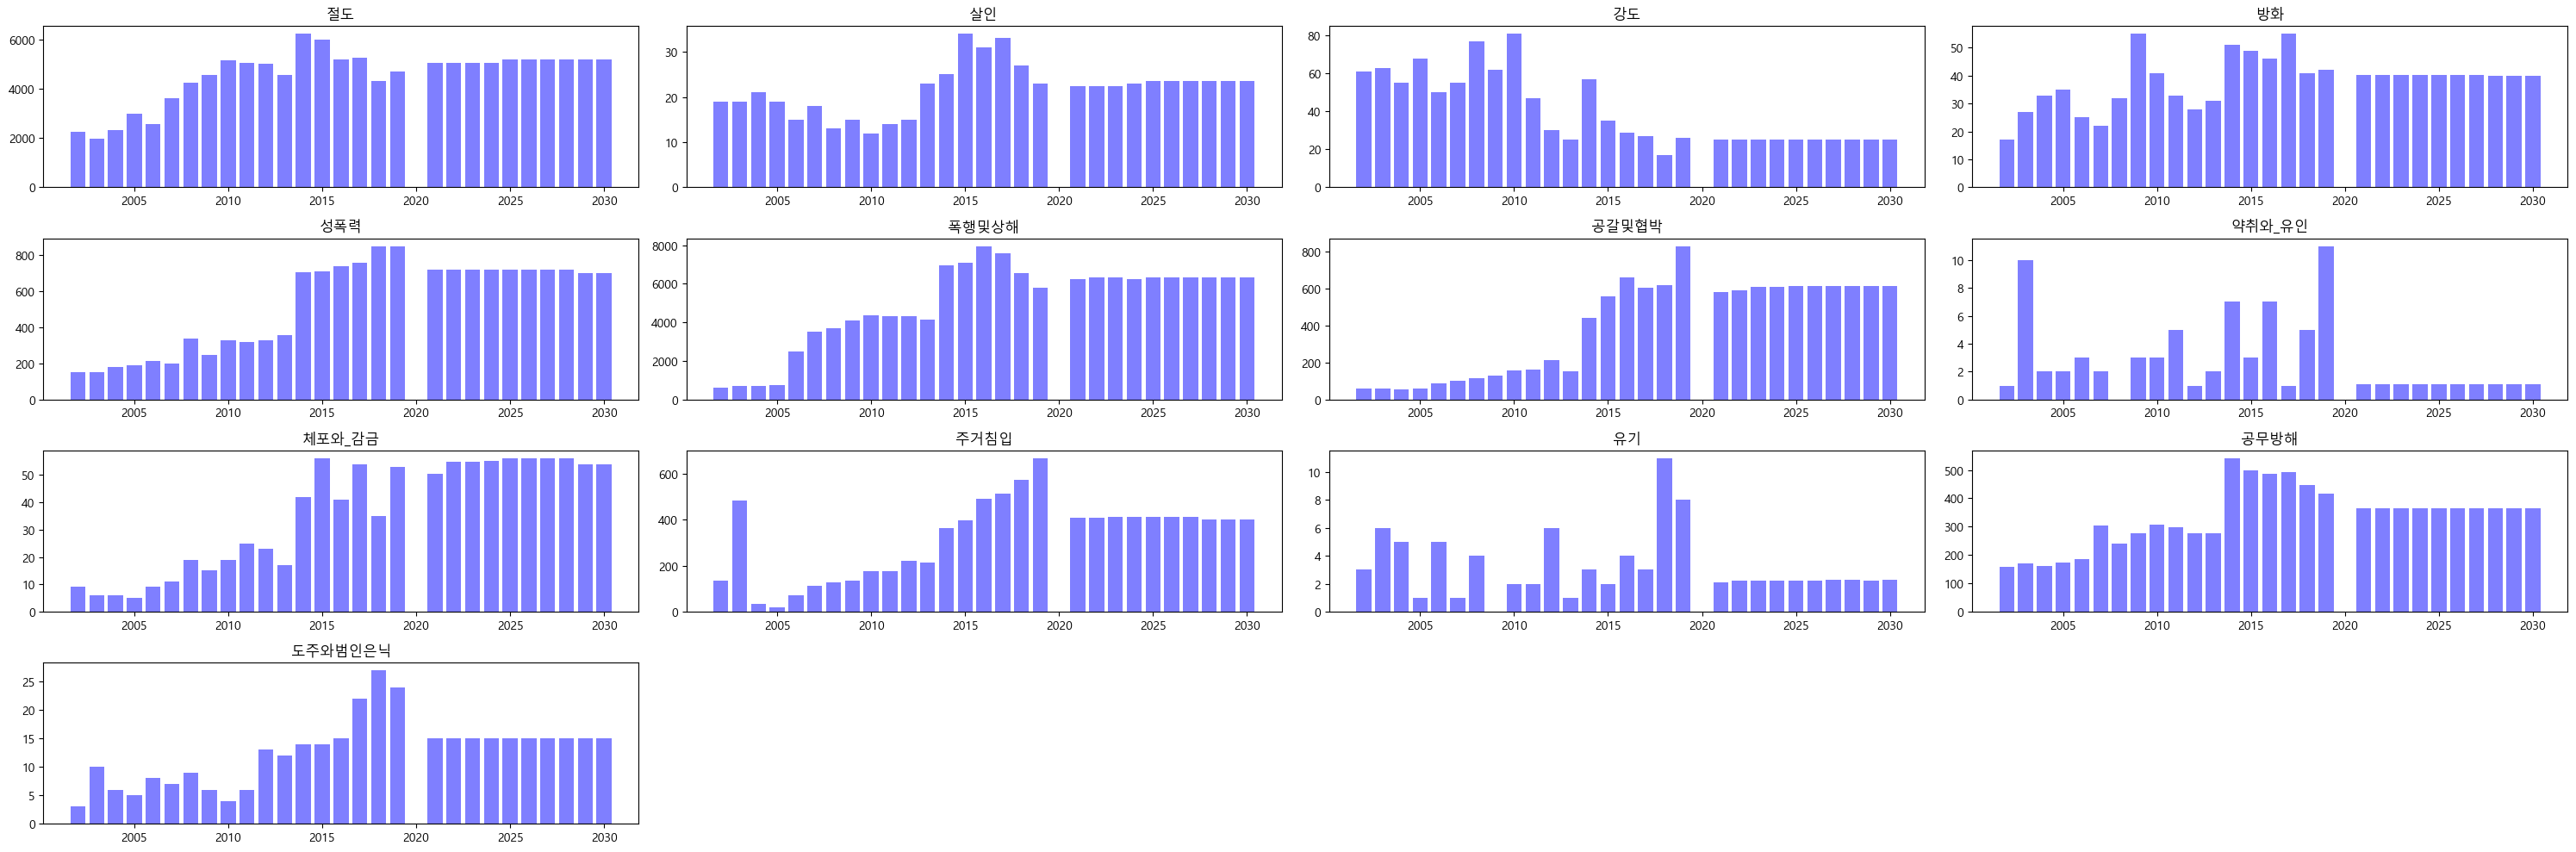

In [314]:
# MinMaxScale1 시도별 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/regression_predict.csv').to_pandas()
mean_predict = mean_predict[mean_predict.시도 != '세종']
tmp_ = mean_predict[mean_predict.시도 == '강원']
tmp_.columns =  list(map(transColName,tmp_.columns))

indi =pd.DataFrame(columns=mean_predict.columns)
# 각 시도별 minmaxScaling
for city in mean_predict.시도.unique():
    scaler.fit(mean_predict[mean_predict.시도 == city].iloc[:,2:])
    indi =indi.append(pd.concat([
        mean_predict[mean_predict.시도 == city][['시도','년도']].reset_index(drop=True),
        pd.DataFrame(
            scaler.transform(mean_predict[mean_predict.시도 ==city].iloc[:,2:]) ,
            columns=mean_predict.columns[2:])
    ],axis = 1))
# indi[indi.시도 == '강원'].head()
# mean_predict[mean_predict.시도 == '강원']['경찰청 인원 1명당 담당 인구'].max()

indi.columns =  list(map(transColName,indi.columns))
x = indi[(indi.년도 >= 2002)&(indi.년도 <= 2019)].sort_values(by = ['시도','년도']).reset_index(drop=True)
predict=  indi[indi.년도 > 2019].sort_values(by = ['시도','년도']).reset_index(drop=True)

df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
df.columns =  list(map(transColName,df.columns))
y = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by = ['시도','년도']).reset_index(drop=True)

xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]
xgboost_tuned = xgboost_tuned[xgboost_tuned['crime'] != '범죄소계']

result = pd.DataFrame()

flag = True
for city in x.시도.unique():
    tmp_pre = pd.DataFrame()
    # 범죄별예측
    for tuned in xgboost_tuned.itertuples():    
        xgb_model = XGBRegressor(
            colsample_bytree = tuned[1],
            gamma = tuned[2],
            learning_rate = tuned[3],
            max_depth = tuned[4],
            min_child_weight = tuned[5],
            n_estimators = tuned[6],
            objective = tuned[7],
            subsample = tuned[8]
        )

        x_train, x_test ,y_train,y_test = train_test_split(x[x.시도 == city].iloc[:,2:],y[y.시도 == city][tuned[9]],test_size=.2)
        xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False) 
        tmp_pre[tuned[9]] = xgb_model.predict(predict.iloc[:,2:]) 
    
    tmp_pre['시도'] = predict[predict.시도 == city].시도
    tmp_pre['년도'] = predict[predict.시도 == city].년도
    tmp_pre = tmp_pre[tmp_pre.columns[-2:].append(tmp_pre.columns[:-2])]
    
    if flag:
        result = tmp_pre
        flag = False
    else:
        result = pd.concat([result,tmp_pre])
        result.reset_index(drop = True)
plot_()


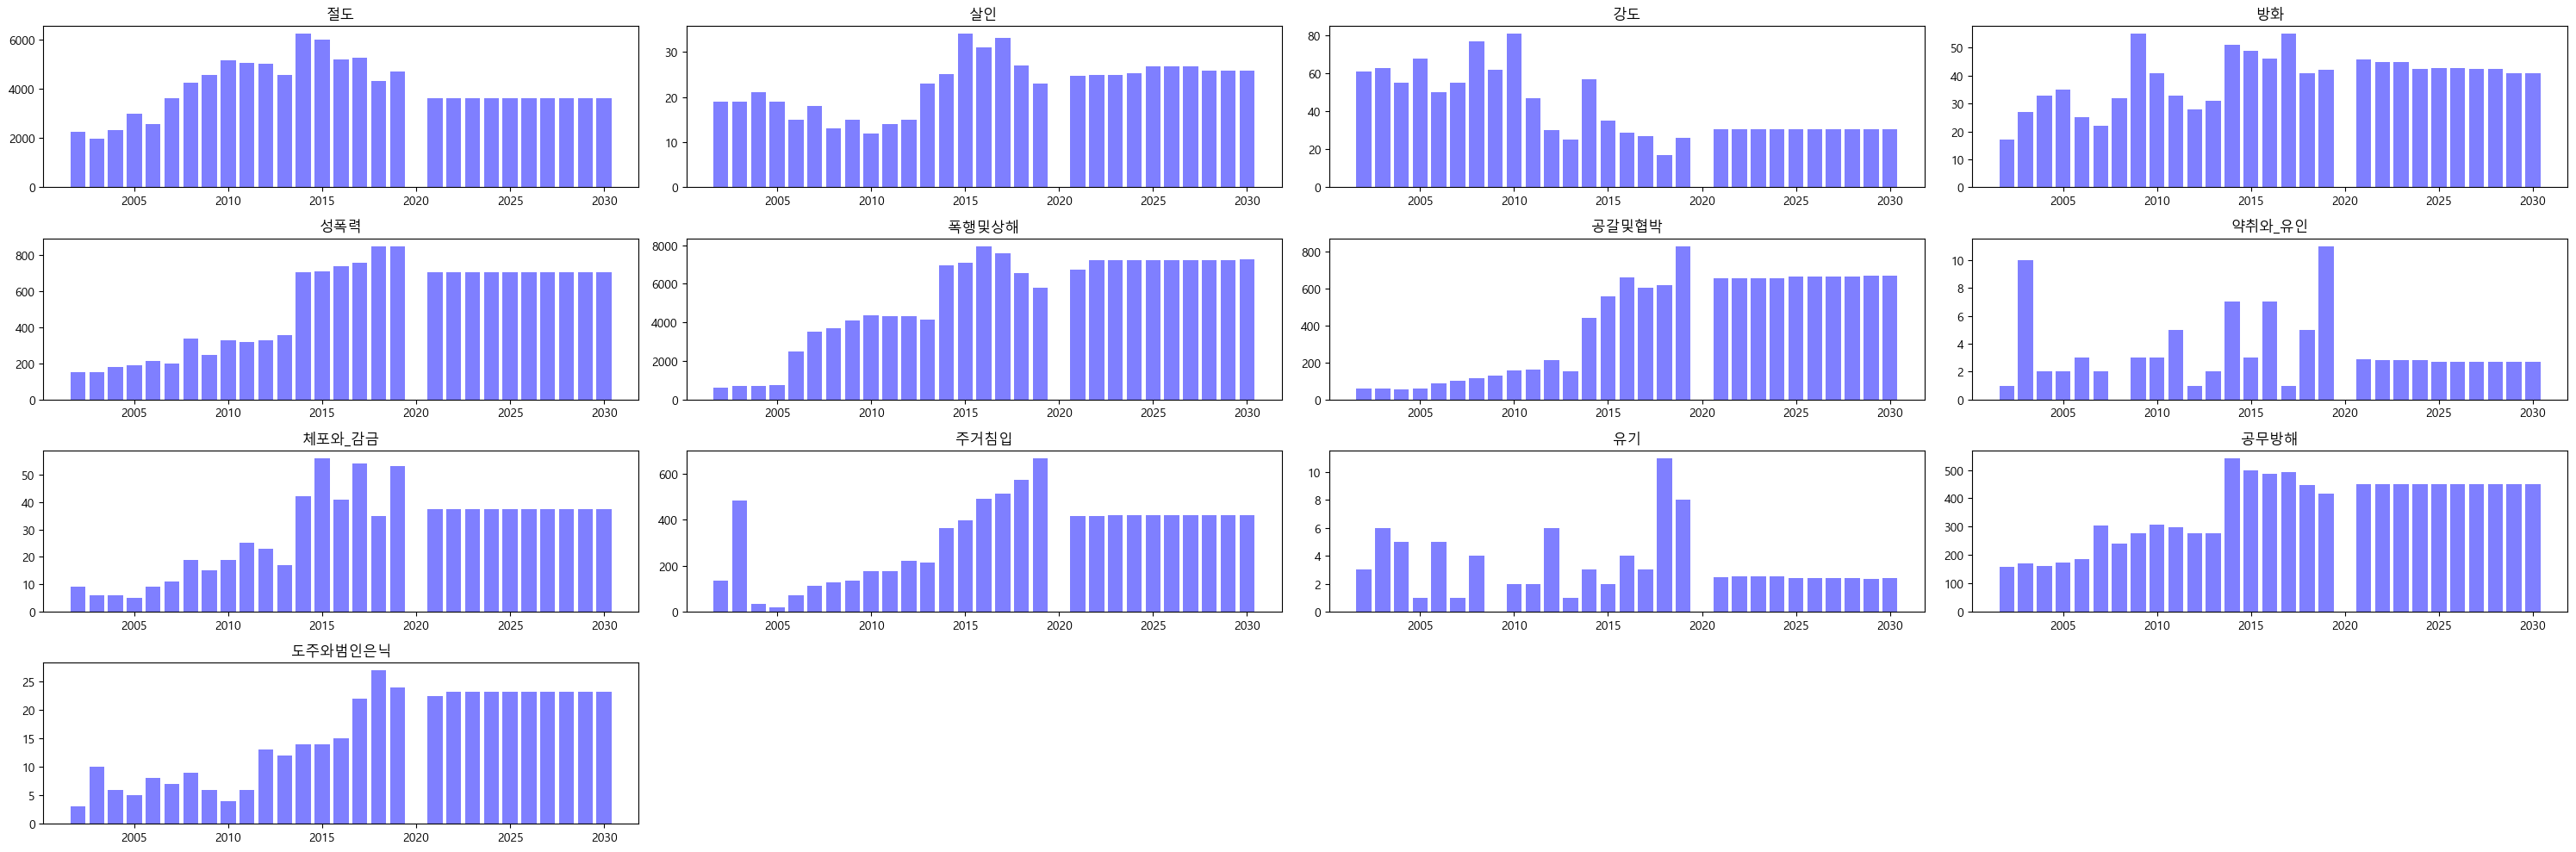

In [319]:
# MinMaxScale1 시도별 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/regression_predict.csv').to_pandas()
mean_predict = mean_predict[mean_predict.시도 != '세종']
tmp_ = mean_predict[mean_predict.시도 == '강원']
tmp_.columns =  list(map(transColName,tmp_.columns))

indi =pd.DataFrame(columns=mean_predict.columns)
# 각 시도별 minmaxScaling
for city in mean_predict.시도.unique():
    scaler.fit(mean_predict[mean_predict.시도 == city].iloc[:,2:])
    indi =indi.append(pd.concat([
        mean_predict[mean_predict.시도 == city][['시도','년도']].reset_index(drop=True),
        pd.DataFrame(
            scaler.transform(mean_predict[mean_predict.시도 ==city].iloc[:,2:]) ,
            columns=mean_predict.columns[2:])
    ],axis = 1))
# indi[indi.시도 == '강원'].head()
# mean_predict[mean_predict.시도 == '강원']['경찰청 인원 1명당 담당 인구'].max()

indi.columns =  list(map(transColName,indi.columns))
x = indi[(indi.년도 >= 2002)&(indi.년도 <= 2019)].sort_values(by = ['시도','년도']).reset_index(drop=True)
predict=  indi[indi.년도 > 2019].sort_values(by = ['시도','년도']).reset_index(drop=True)

df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
df.columns =  list(map(transColName,df.columns))
y = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by = ['시도','년도']).reset_index(drop=True)

xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]
xgboost_tuned = xgboost_tuned[xgboost_tuned['crime'] != '범죄소계']

result = pd.DataFrame()

flag = True
for city in x.시도.unique():
    tmp_pre = pd.DataFrame()
    # 범죄별예측
    for tuned in xgboost_tuned.itertuples():    
        xgb_model = XGBRegressor(
            colsample_bytree = tuned[1],
            gamma = tuned[2],
            learning_rate = tuned[3],
            max_depth = tuned[4],
            min_child_weight = tuned[5],
            n_estimators = tuned[6],
            objective = tuned[7],
            subsample = tuned[8]
        )

        x_train, x_test ,y_train,y_test = train_test_split(x[x.시도 == city].iloc[:,2:],y[y.시도 == city][tuned[9]],test_size=.2)
        xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False) 
        tmp_pre[tuned[9]] = xgb_model.predict(predict.iloc[:,2:]) 
    
    tmp_pre['시도'] = predict[predict.시도 == city].시도
    tmp_pre['년도'] = predict[predict.시도 == city].년도
    tmp_pre = tmp_pre[tmp_pre.columns[-2:].append(tmp_pre.columns[:-2])]
    
    if flag:
        result = tmp_pre
        flag = False
    else:
        result = pd.concat([result,tmp_pre])
        result.reset_index(drop = True)
plot_()


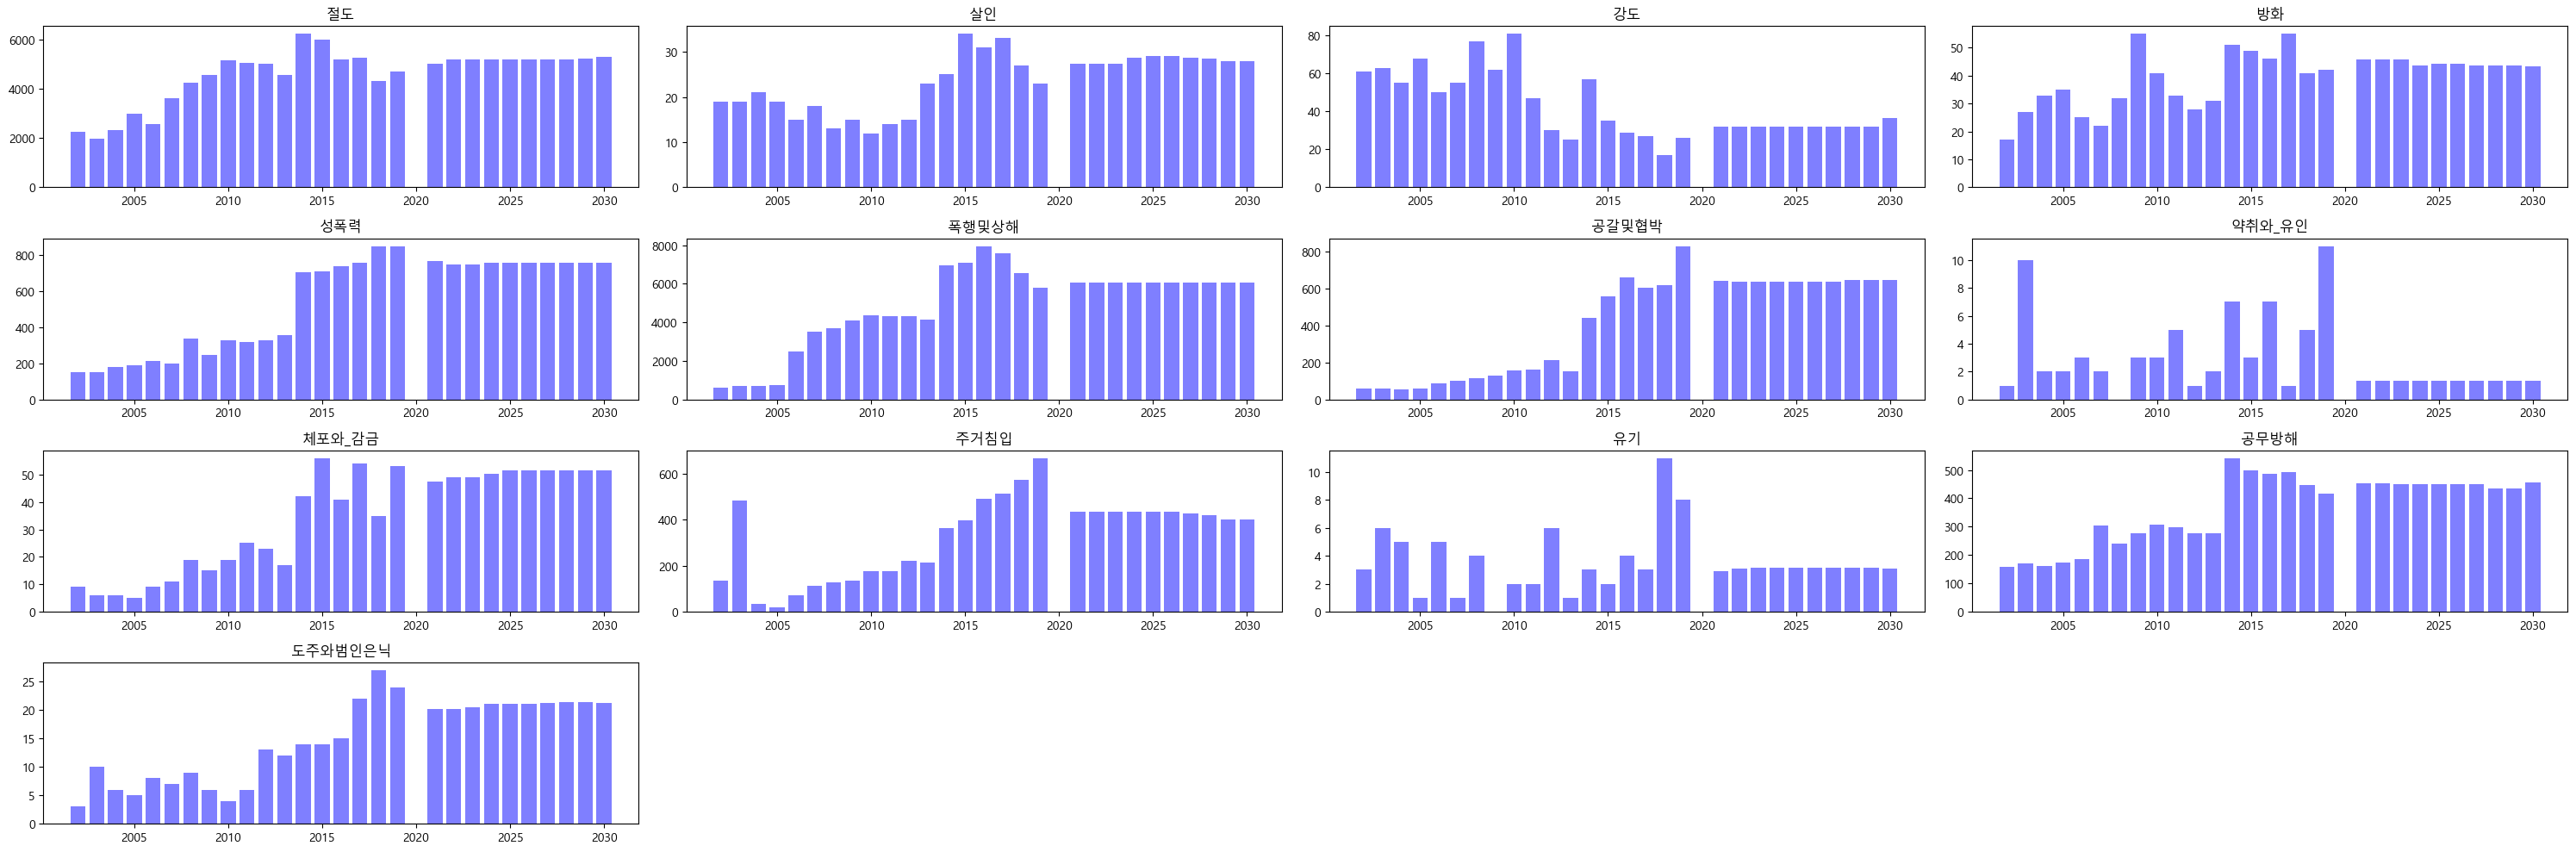

In [320]:
# MinMaxScale1 시도별 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/regression_predict.csv').to_pandas()
mean_predict = mean_predict[mean_predict.시도 != '세종']
tmp_ = mean_predict[mean_predict.시도 == '강원']
tmp_.columns =  list(map(transColName,tmp_.columns))

indi =pd.DataFrame(columns=mean_predict.columns)
# 각 시도별 minmaxScaling
for city in mean_predict.시도.unique():
    scaler.fit(mean_predict[mean_predict.시도 == city].iloc[:,2:])
    indi =indi.append(pd.concat([
        mean_predict[mean_predict.시도 == city][['시도','년도']].reset_index(drop=True),
        pd.DataFrame(
            scaler.transform(mean_predict[mean_predict.시도 ==city].iloc[:,2:]) ,
            columns=mean_predict.columns[2:])
    ],axis = 1))
# indi[indi.시도 == '강원'].head()
# mean_predict[mean_predict.시도 == '강원']['경찰청 인원 1명당 담당 인구'].max()

indi.columns =  list(map(transColName,indi.columns))
x = indi[(indi.년도 >= 2002)&(indi.년도 <= 2019)].sort_values(by = ['시도','년도']).reset_index(drop=True)
predict=  indi[indi.년도 > 2019].sort_values(by = ['시도','년도']).reset_index(drop=True)

df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
df.columns =  list(map(transColName,df.columns))
y = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by = ['시도','년도']).reset_index(drop=True)

xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]
xgboost_tuned = xgboost_tuned[xgboost_tuned['crime'] != '범죄소계']

result = pd.DataFrame()

flag = True
for city in x.시도.unique():
    tmp_pre = pd.DataFrame()
    # 범죄별예측
    for tuned in xgboost_tuned.itertuples():    
        xgb_model = XGBRegressor(
            colsample_bytree = tuned[1],
            gamma = tuned[2],
            learning_rate = tuned[3],
            max_depth = tuned[4],
            min_child_weight = tuned[5],
            n_estimators = tuned[6],
            objective = tuned[7],
            subsample = tuned[8]
        )

        x_train, x_test ,y_train,y_test = train_test_split(x[x.시도 == city].iloc[:,2:],y[y.시도 == city][tuned[9]],test_size=.2)
        xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False) 
        tmp_pre[tuned[9]] = xgb_model.predict(predict.iloc[:,2:]) 
    
    tmp_pre['시도'] = predict[predict.시도 == city].시도
    tmp_pre['년도'] = predict[predict.시도 == city].년도
    tmp_pre = tmp_pre[tmp_pre.columns[-2:].append(tmp_pre.columns[:-2])]
    
    if flag:
        result = tmp_pre
        flag = False
    else:
        result = pd.concat([result,tmp_pre])
        result.reset_index(drop = True)
plot_()


SyntaxError: invalid syntax (<ipython-input-1-86266b1f7d38>, line 1)

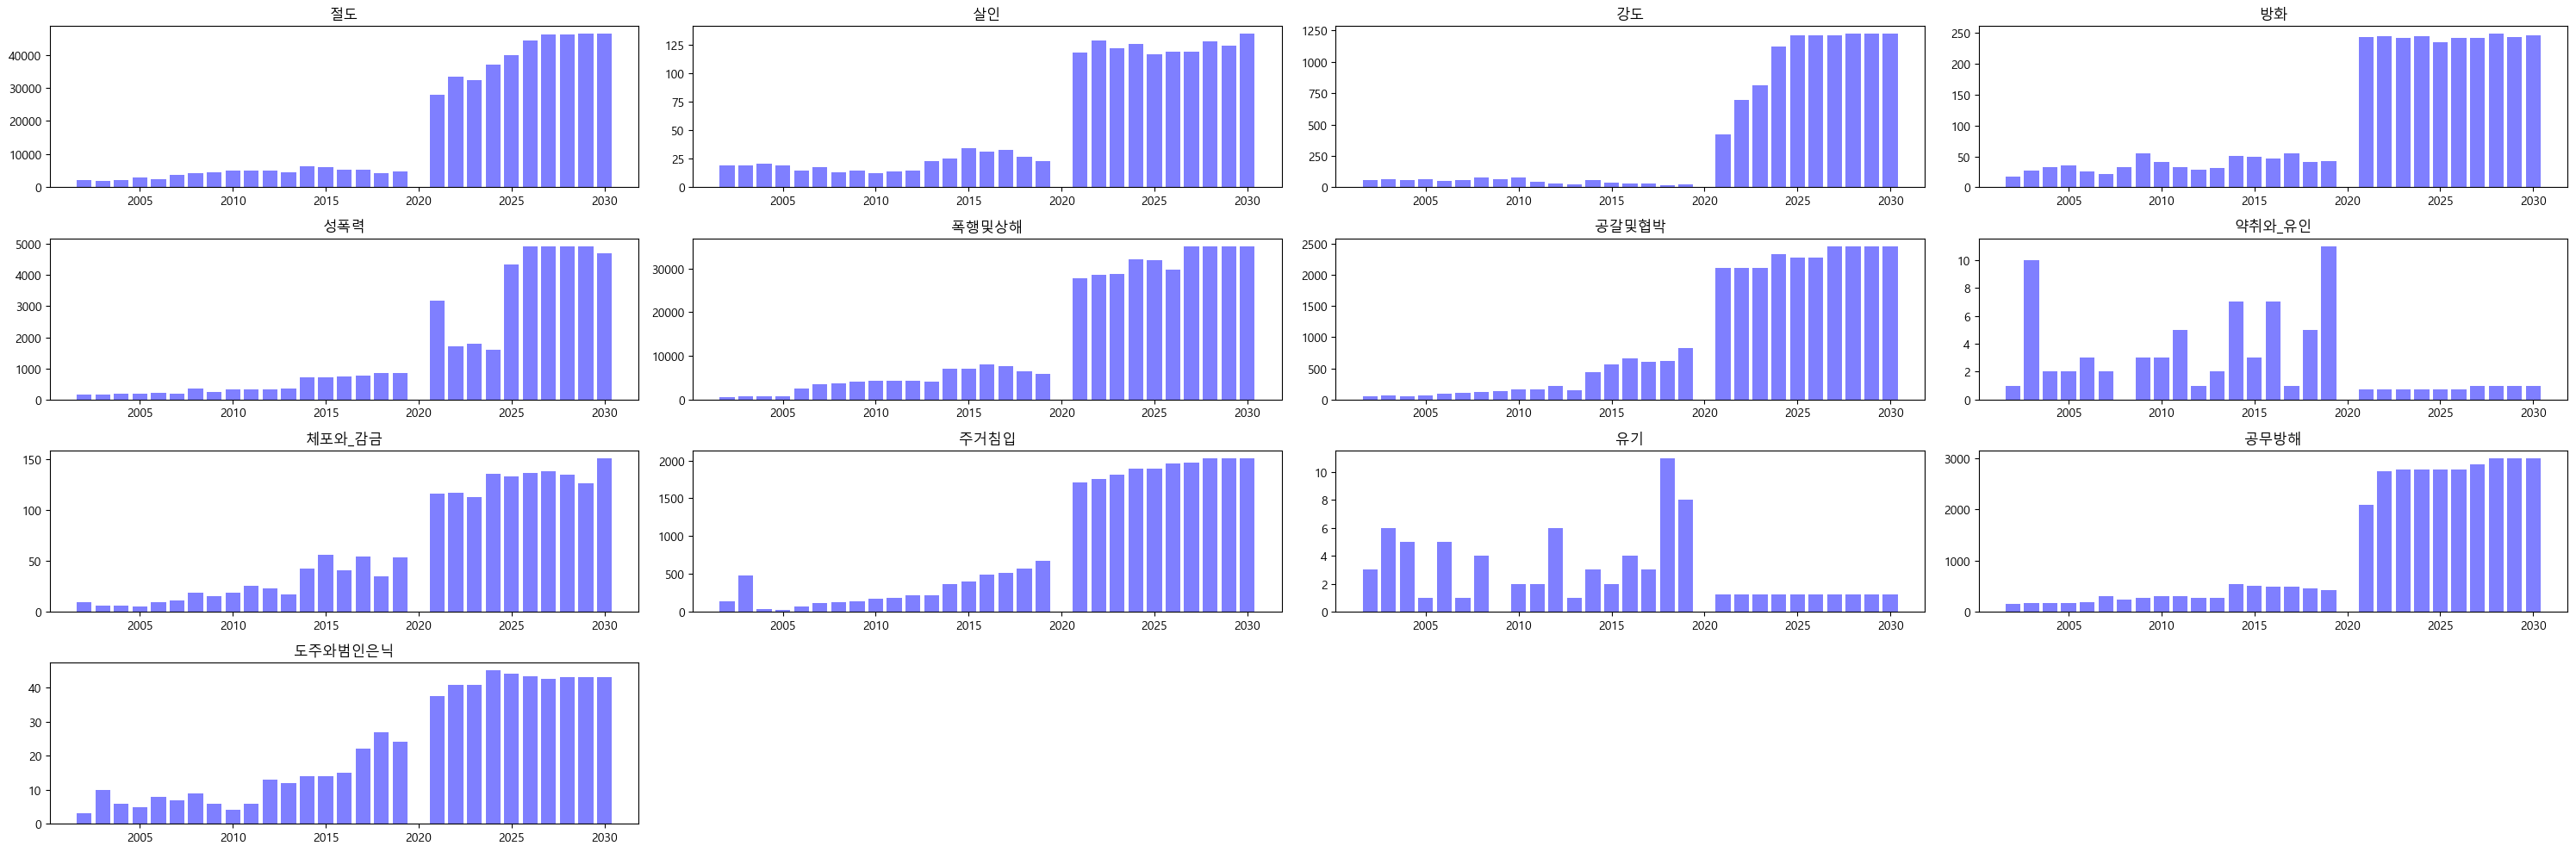

In [317]:
# MinMaxScale1 시도별 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/regression_predict.csv').to_pandas()
mean_predict = mean_predict[mean_predict.시도 != '세종']
tmp_ = mean_predict[mean_predict.시도 == '강원']
tmp_.columns =  list(map(transColName,tmp_.columns))

indi =pd.DataFrame(columns=mean_predict.columns)
# 각 시도별 minmaxScaling
for city in mean_predict.시도.unique():
    scaler.fit(mean_predict[mean_predict.시도 == city].iloc[:,2:])
    indi =indi.append(pd.concat([
        mean_predict[mean_predict.시도 == city][['시도','년도']].reset_index(drop=True),
        pd.DataFrame(
            scaler.transform(mean_predict[mean_predict.시도 ==city].iloc[:,2:]) ,
            columns=mean_predict.columns[2:])
    ],axis = 1))
# indi[indi.시도 == '강원'].head()
# mean_predict[mean_predict.시도 == '강원']['경찰청 인원 1명당 담당 인구'].max()

indi.columns =  list(map(transColName,indi.columns))
x = indi[(indi.년도 >= 2002)&(indi.년도 <= 2019)].sort_values(by = ['시도','년도']).reset_index(drop=True)
predict=  indi[indi.년도 > 2019].sort_values(by = ['시도','년도']).reset_index(drop=True)

df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
df.columns =  list(map(transColName,df.columns))
y = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by = ['시도','년도']).reset_index(drop=True)

xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]
xgboost_tuned = xgboost_tuned[xgboost_tuned['crime'] != '범죄소계']

result = pd.DataFrame()

for tuned in xgboost_tuned.itertuples():    
    xgb_model = XGBRegressor(
        colsample_bytree = tuned[1],
        gamma = tuned[2],
        learning_rate = tuned[3],
        max_depth = tuned[4],
        min_child_weight = tuned[5],
        n_estimators = tuned[6],
        objective = tuned[7],
        subsample = tuned[8]
    )
    x_train, x_test ,y_train,y_test = train_test_split(x.iloc[:,2:],y[tuned[9]],test_size=.2)
    xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False) 
    result[tuned[9]] = xgb_model.predict(predict.iloc[:,2:]) 

result['시도'] = predict.시도
result['년도'] = predict.년도
result = result[result.columns[-2:].append(result.columns[:-2])]
# result = pd.concat([result,tmp_pre])
result
plot_()

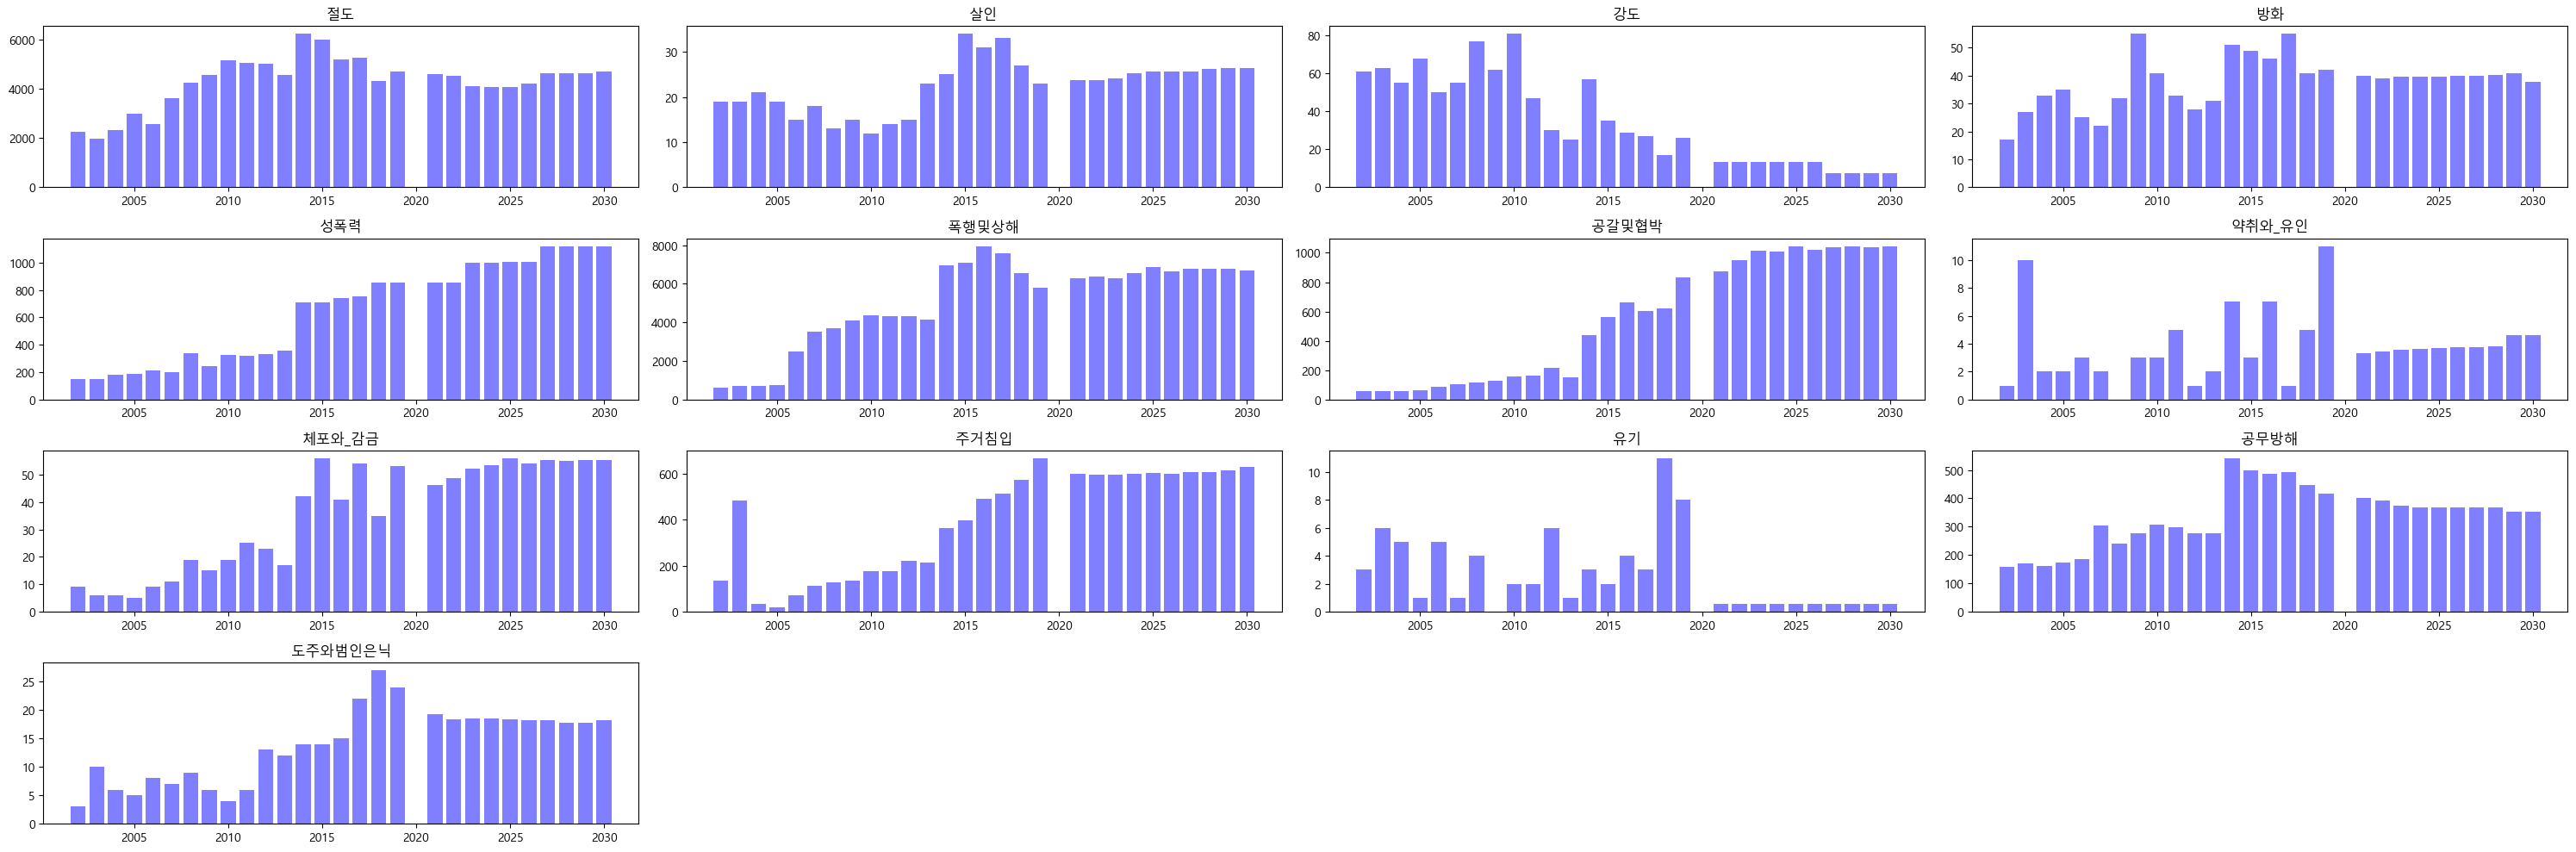

In [278]:
from matplotlib import font_manager,rc
from matplotlib import pyplot as plt
import math
def plot_():
    plt.rcParams["figure.figsize"] = (30, 10)
    
    df= result.append(y)
    df.columns =  list(map(transColName,df.columns))
    
    font_path = "C:/Windows/Fonts/malgunbd.ttf" # 폰트 파일 위치
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
    cnt = 1
    plot_shape = math.ceil(math.sqrt(len(df.columns))) 
    plt.clf() 
    for colName in df.columns[2:]:
        # plt.figure(figsize=(6,8))
        
        plt.rcParams["figure.figsize"] = (30, 10)
        plt.subplot(plot_shape,plot_shape,cnt)
        plt.bar(df[df.시도 == '강원']['년도'],df[df.시도 == '강원'][colName],color = 'blue',alpha=0.5)
        plt.title(colName)
        plt.tight_layout()
        cnt+=1
    # plt.savefig('../img/'+fileName)
    plt.show()

,시도,년도,이혼율,경제활동인구,비경제활동인구,취업자,고용률 (%),실업자,실업률 (%),1인당 지역내총생산,...,경찰청 인원 1명당 담당 인구,한국인(총인구수[명]),한국인(남녀비율[백분율]),한국인(인구밀도),총전입 (명),총전출 (명),대학교 수,종교단체수,외국인수,총인구수 (명)
0,강원,2000,0.438167,0.048780,0.076232,0.049400,0.222857,0.038946,0.224138,0.030091,...,0.436721,0.067211,0.600709,0.000178,0.124144,0.117797,0.269530,0.109667,0.043111,0.067211
1,강원,2001,0.550533,0.047737,0.078326,0.048677,0.188571,0.032955,0.172414,0.038377,...,0.427254,0.067059,0.577533,0.000170,0.092046,0.093050,0.268066,0.113213,0.043930,0.067059
2,강원,2002,0.578625,0.050055,0.074347,0.051328,0.297143,0.023967,0.086207,0.050972,...,0.417788,0.066151,0.578395,0.000122,0.093945,0.099128,0.266601,0.115178,0.044750,0.066151
3,강원,2003,0.690992,0.048201,0.077488,0.049280,0.217143,0.026963,0.120690,0.067948,...,0.408322,0.065375,0.601780,0.000081,0.101752,0.101817,0.276670,0.120852,0.040992,0.065375
4,강원,2004,0.522442,0.049476,0.075603,0.050605,0.262857,0.029959,0.137931,0.078258,...,0.398856,0.064999,0.608622,0.000061,0.105444,0.103725,0.276670,0.123853,0.042554,0.064999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,서울,2026,0.072067,0.620534,0.665581,0.617941,0.404700,0.684983,0.487075,0.531784,...,0.429653,0.610998,0.076902,0.944688,0.749323,0.777800,0.677092,0.534193,0.556959,0.610998
476,서울,2027,0.054050,0.623130,0.667550,0.620642,0.407098,0.684872,0.483575,0.549068,...,0.441405,0.609491,0.057676,0.942477,0.743926,0.772459,0.674000,0.535729,0.565915,0.609491
477,서울,2028,0.036033,0.625727,0.669520,0.623343,0.409495,0.684762,0.480075,0.566352,...,0.453156,0.607985,0.038451,0.940265,0.738529,0.767117,0.670908,0.537264,0.574871,0.607985
478,서울,2029,0.018017,0.628324,0.671490,0.626044,0.411893,0.684652,0.476575,0.583636,...,0.464907,0.606479,0.019225,0.938054,0.733132,0.761775,0.667816,0.538800,0.583827,0.606479


# 모든 종속변수 스케일링 ( 지역별로 구분 안함 )

In [94]:
# 모든 범죄에 대한 HyperParameter 구하기
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/mean_predict.csv').to_pandas()
mean_predict = mean_predict[mean_predict.시도 != '세종'] 

scaler.fit(mean_predict.iloc[:,2:])
indi = pd.concat(
    [mean_predict.iloc[:,:2],
        pd.DataFrame(scaler.transform(mean_predict.iloc[:,2:]),columns = mean_predict.columns[2:])
        ],axis = 1
)

indi.columns =  list(map(transColName,indi.columns))
x = indi[(indi.년도 >= 2002)&(indi.년도 <= 2019)].sort_values(by = ['시도','년도']).reset_index(drop=True)

df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
df.columns =  list(map(transColName,df.columns))
y = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by = ['시도','년도']).reset_index(drop=True)

result = pd.DataFrame()
flag = True
for colName in y.columns[2:]:
    
    x_train, x_test ,y_train,y_test = train_test_split(x.iloc[:,2:],y[colName],test_size=.2)
    hyper_tuned  = pd.DataFrame([hyperParameterTuning(x_train,y_train)])
    hyper_tuned['crime'] = colName
    if flag:
        result = hyper_tuned.copy()
        flag =False
    else :
        result = result.append(hyper_tuned)    


result.to_csv('xgboost_tuned_mean_scaled.csv',encoding="utf-8-sig")

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


C:\Users\painc\Anaconda3\envs\iitp_keras\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


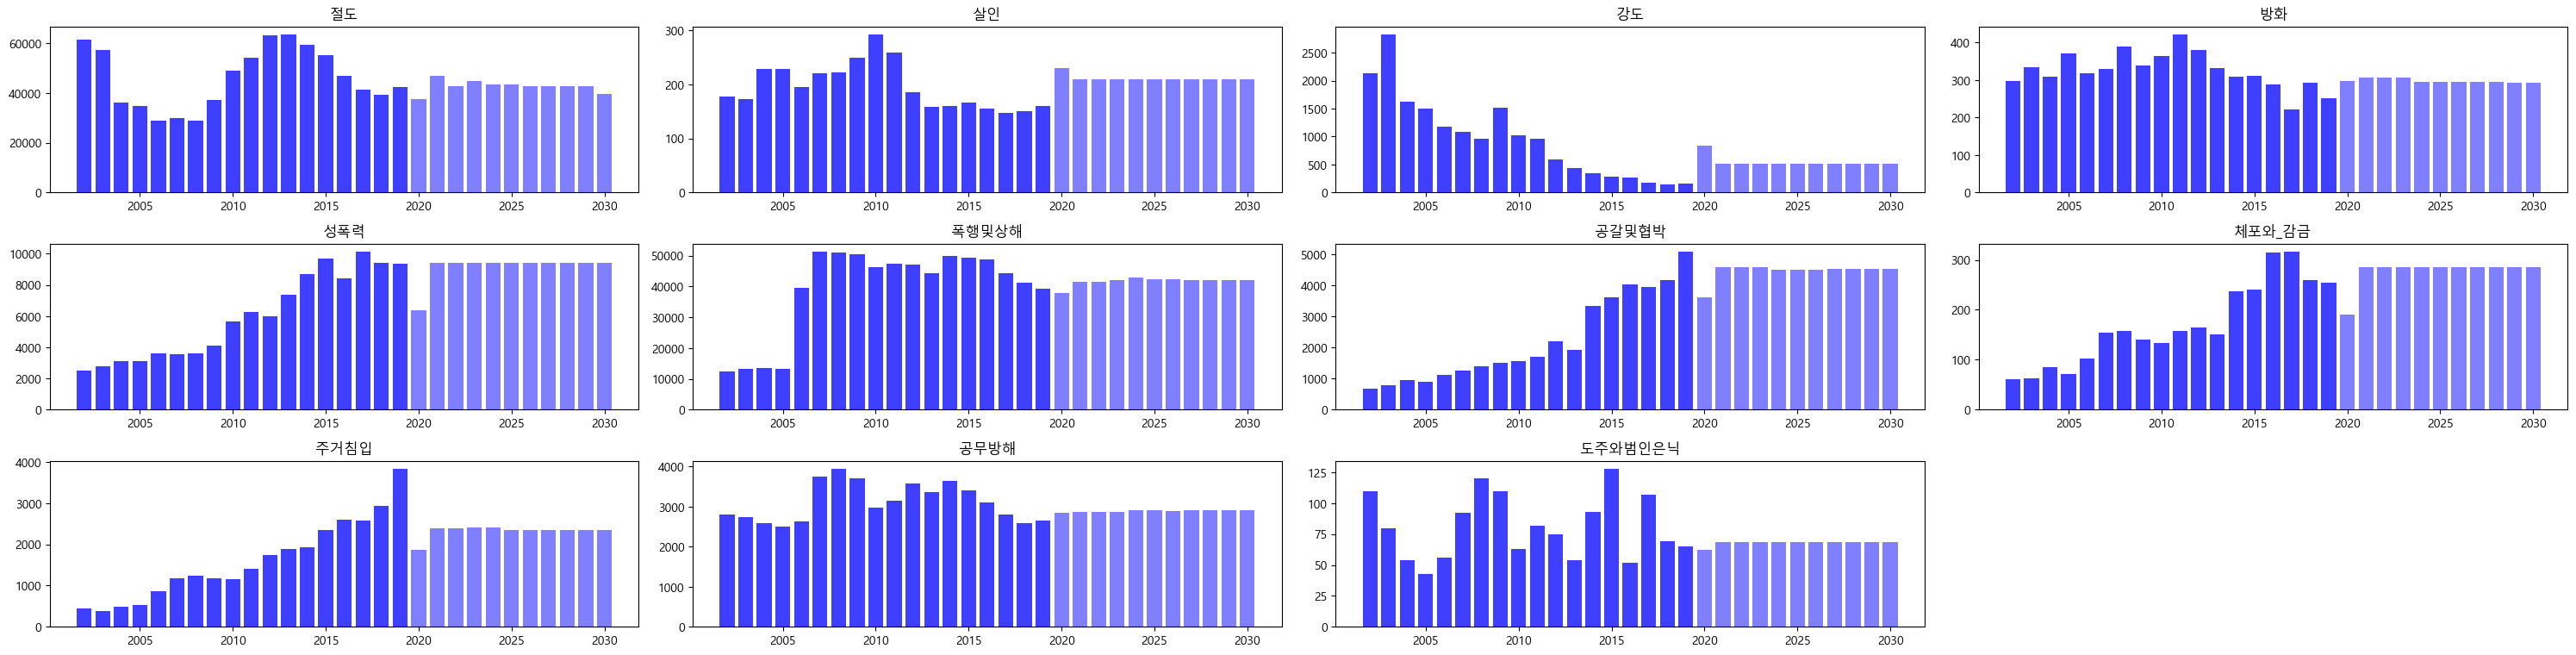

In [105]:
# MinMaxScale1 모든 지역으로 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/mean_predict.csv').to_pandas()
# mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/regression_predict.csv').to_pandas()
# mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/zero_predict.csv').to_pandas()
mean_predict = mean_predict[mean_predict.시도 != '세종'] 

scaler.fit(mean_predict.iloc[:,2:])
indi = pd.concat(
    [mean_predict.iloc[:,:2],
        pd.DataFrame(scaler.transform(mean_predict.iloc[:,2:]),columns = mean_predict.columns[2:])
        ],axis = 1
)


indi.columns =  list(map(transColName,indi.columns))
x = indi[(indi.년도 >= 2002)&(indi.년도 <= 2019)].sort_values(by = ['시도','년도']).reset_index(drop=True)
predict=  indi[indi.년도 > 2019].sort_values(by = ['시도','년도']).reset_index(drop=True)

df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
df.columns =  list(map(transColName,df.columns))
y = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by = ['시도','년도']).reset_index(drop=True)

# xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = csv.read_csv('xgboost_tuned_mean_scaled.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]
xgboost_tuned = xgboost_tuned[xgboost_tuned['crime'] != '범죄소계']

result = pd.DataFrame()

for tuned in xgboost_tuned.itertuples():    
    xgb_model = XGBRegressor(
        colsample_bytree = tuned[1],
        gamma = tuned[2],
        learning_rate = tuned[3],
        max_depth = tuned[4],
        min_child_weight = tuned[5],
        n_estimators = tuned[6],
        objective = tuned[7],
        subsample = tuned[8]
    )
    x_train, x_test ,y_train,y_test = train_test_split(x.iloc[:,2:],y[tuned[9]],test_size=.2)
    xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False) 
    result[tuned[9]] = xgb_model.predict(predict.iloc[:,2:]) 

result['시도'] = predict.시도
result['년도'] = predict.년도
result = result[result.columns[-2:].append(result.columns[:-2])]

result = pd.concat([y,result])
result.sort_values(by = ['시도','년도'],inplace= True) 
result = result.drop(['유기','약취와_유인'],axis =1 )
y = y.drop(['유기','약취와_유인'],axis =1 )
result.to_csv('crime_predicted_xgboost_mean_scaled.csv',encoding="utf-8-sig",index=False)
plot_('서울')


# Top 5 corr를 이용하여 예측

In [90]:
import ast

# top_five_[top_five_.범죄 == tuned[9]].칼럼리스트.values[0]
# print(type(top_five_[top_five_.범죄 == tuned[9]].칼럼리스트.values[0]))
top_five_ =csv.read_csv(config['data_path']+ 'csv/cleaned/Top_Five_Cols.csv').to_pandas()
x = indi[(indi.년도 >= 2002)&(indi.년도 <= 2019)].sort_values(by = ['시도','년도']).reset_index(drop=True)
# x[ast.literal_eval(top_five_[top_five_.범죄 == tuned[9]].칼럼리스트.values[0])]
for i in top_five_.범죄:
    # top_five_[top_five_.범죄 == i]['범죄'] = transColName(top_five_[top_five_.범죄 == i]['범죄'])
    # print(transColName(top_five_[top_five_.범죄 == i]['범죄']))
    # print(top_five_[top_five_.범죄 == i]['범죄'])

# transColName(top_five_[top_five_.범죄 == '살인']['범죄'].values)


IndentationError: expected an indented block (<ipython-input-90-f03f449a0f90>, line 14)

In [95]:
top_five_

,범죄,칼럼리스트
0,절도,"['인당_민간소비', '비경제활동인구', 'PC방', '외국인수', '종교단체수']"
1,살인,"['경찰청_인원_명당_담당_인구', '대학교_수', '취업자', '실업자', '경제..."
2,강도,"['인당_지역내총생산', '인당_개인소득', '인당_민간소비', '인당_지역총소득'..."
3,방화,"['인당_개인소득', '인당_민간소비', '음식점', '유흥가', '외국인수']"
4,성폭력,"['인당_지역총소득', '인당_개인소득', '인당_민간소비', '음식점', '외국인수']"
5,폭행및상해,"['인당_개인소득', '인당_민간소비', '종교단체수', '외국인수', 'PC방']"
6,공갈및협박,"['인당_지역내총생산', '인당_지역총소득', '인당_개인소득', '인당_민간소비'..."
7,약취와 유인,"['이혼율', 'PC방', '경찰청_소속_경찰관_수', '경찰청_인원_명당_담당_인..."
8,체포와 감금,"['인당_지역총소득', '인당_개인소득', '인당_민간소비', '음식점', '외국인수']"
9,주거침입,"['인당_지역내총생산', '인당_지역총소득', '인당_개인소득', '인당_민간소비'..."


In [40]:
# MinMaxScale1 모든 지역으로 스케일링 Top 5칼럼
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mean_predict = csv.read_csv(config['data_path']+ 'csv/cleaned/independent/mean_predict.csv').to_pandas()
mean_predict = mean_predict[mean_predict.시도 != '세종'] 

scaler.fit(mean_predict.iloc[:,2:])
indi = pd.concat(
    [mean_predict.iloc[:,:2],
        pd.DataFrame(scaler.transform(mean_predict.iloc[:,2:]),columns = mean_predict.columns[2:])
        ],axis = 1
)


indi.columns =  list(map(transColName,indi.columns))
x = indi[(indi.년도 >= 2002)&(indi.년도 <= 2019)].sort_values(by = ['시도','년도']).reset_index(drop=True)
predict=  indi[indi.년도 > 2019].sort_values(by = ['시도','년도']).reset_index(drop=True)

df = csv.read_csv(config['data_path']+ 'csv/cleaned/crime_merged.csv').to_pandas()
df.columns =  list(map(transColName,df.columns))
y = df[(df.년도 >= 2002)&(df.년도 <= 2019)&(df.시도 != '세종')].iloc[:,:15].sort_values(by = ['시도','년도']).reset_index(drop=True)

# xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = csv.read_csv('xgboost_tuned_mean_scaled.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]
xgboost_tuned = xgboost_tuned[xgboost_tuned['crime'] != '범죄소계']

result = pd.DataFrame()

top_five_ =csv.read_csv(config['data_path']+ 'csv/cleaned/Top_Five_Cols.csv').to_pandas()

for tuned in xgboost_tuned.itertuples():    
    xgb_model = XGBRegressor(
        colsample_bytree = tuned[1],
        gamma = tuned[2],
        learning_rate = tuned[3],
        max_depth = tuned[4],
        min_child_weight = tuned[5],
        n_estimators = tuned[6],
        objective = tuned[7],
        subsample = tuned[8]
    )
    x_train, x_test ,y_train,y_test = train_test_split(
        # x.iloc[:,2:][ast.literal_eval(top_five_[top_five_.범죄 == tuned[9]].칼럼리스트.values[0])],
        x[ast.literal_eval(top_five_[top_five_['범죄'] == tuned[9]]['칼럼리스트'].values[0])],
        y[tuned[9]],
        test_size=.2
        )
    xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False) 
    # result[tuned[9]] = xgb_model.predict(predict.iloc[:,2:]) 
    result[tuned[9]] = xgb_model.predict(predict[ast.literal_eval(top_five_[top_five_.범죄 == tuned[9]].칼럼리스트.values[0])]) 

result['시도'] = predict.시도
result['년도'] = predict.년도
result = result[result.columns[-2:].append(result.columns[:-2])]

result = pd.concat([y,result])
result.sort_values(by = ['시도','년도'],inplace= True) 
result = result.drop(['유기','약취와_유인'],axis =1 )
y = y.drop(['유기','약취와_유인'],axis =1 )
# result.to_csv('crime_predicted_xgboost_mean_scaled.csv',encoding="utf-8-sig",index=False)
plot_('서울')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [54]:
# MinMaxScale1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
predict_2019 = mean_predict[(mean_predict.년도 >= 2002)&(mean_predict.년도 <= 2019)&(mean_predict.시도 != '세종')].sort_values(by=['시도','년도'])
predict_2019.columns =  list(map(transColName,predict_2019.columns))
indi =pd.DataFrame(columns=predict_2019.columns)


# 각 시도별 minmaxScaling
for city in predict_2019.시도.unique():
    scaler.fit(predict_2019[predict_2019.시도 == city].iloc[:,2:])
    indi =indi.append(pd.concat([
        predict_2019[predict_2019.시도 == city][['시도','년도']].reset_index(drop=True),
        pd.DataFrame(
            scaler.transform(predict_2019[predict_2019.시도 ==city].iloc[:,2:]) ,
            columns=predict_2019.columns[2:])
    ],axis = 1))
indi

    
indi = indi.sort_values(by =['시도','년도'])
crime_val = crime_val.sort_values(by =['시도','년도'])
xgboost_tuned = csv.read_csv('xgboost_tuned.csv').to_pandas()
xgboost_tuned = xgboost_tuned.iloc[:,1:]

for tuned in xgboost_tuned.itertuples():    
    xgb_model = XGBRegressor(
        colsample_bytree = tuned[1],
        gamma = tuned[2],
        learning_rate = tuned[3],
        max_depth = tuned[4],
        min_child_weight = tuned[5],
        n_estimators = tuned[6],
        objective = tuned[7],
        subsample = tuned[8]
    )
    x_train, x_test ,y_train,y_test = train_test_split(indi.iloc[:,2:],crime_val[tuned[9]],test_size=.2)
    xgb_model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=False)
    result[tuned[9]] = xgb_model.predict(indi.iloc[-1,2:])
result



KeyError: '시도'

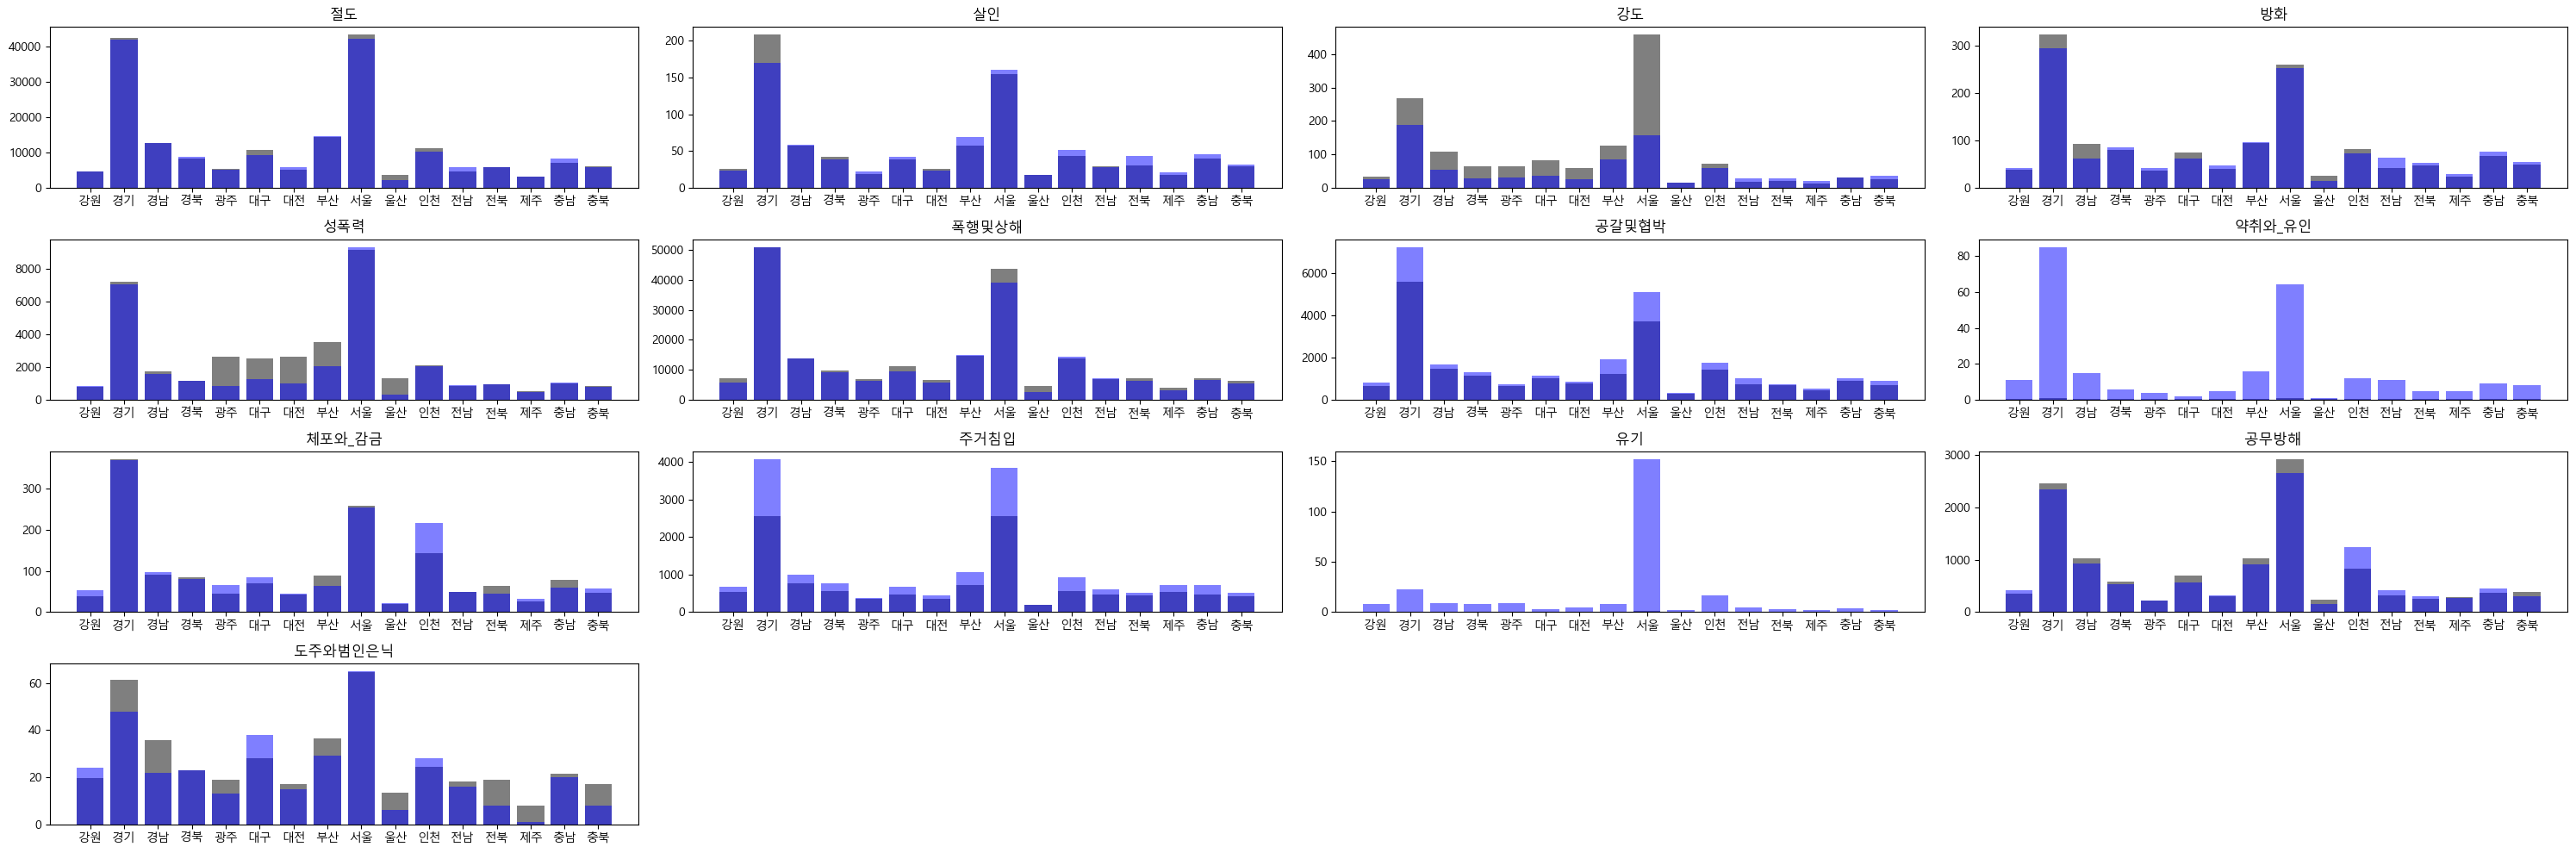

In [156]:
from matplotlib import font_manager,rc
from matplotlib import pyplot as plt
import math
plt.rcParams["figure.figsize"] = (30, 10)
df.columns =  list(map(transColName,df.columns))
font_path = "C:/Windows/Fonts/malgunbd.ttf" # 폰트 파일 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
cnt = 1
plot_shape = math.ceil(math.sqrt(len(df.columns))) 
for colName in tmp.columns[1:]:
    # plt.figure(figsize=(6,8))
    plt.rcParams["figure.figsize"] = (30, 10)
    plt.subplot(plot_shape,plot_shape,cnt)
    # tmp[colName].plot()
    plt.bar(tmp['시도'],tmp[colName],color = 'black',alpha=0.5)
    plt.bar(df['시도'],df[colName+'real'],color = 'blue',alpha=0.5)
    plt.title(colName)
    plt.tight_layout()
    cnt+=1
# plt.savefig('../img/'+fileName)
plt.show()